**Model Skeleton**

Click [here](https://docs.google.com/document/d/15i4WKK-kaqgAb90PQ_iMbMJgdA57clu9iYEen_DVmyc/edit?usp=sharing) for a detailed description of the purpose of every code chunk

**Make sure to run this script on Google Colab to ensure compatability with Drive mounting**

**0) Import Dependencies and Mount Drive**

In [ ]:
# ─── Standard Library ───────────────────────────────────────────────────────
import os
import re
import glob
import time
import struct
import random
import shutil
from datetime import datetime
from collections import Counter, OrderedDict
from concurrent.futures import ThreadPoolExecutor, as_completed
from pathlib import Path

# ─── Data Handling ──────────────────────────────────────────────────────────
import numpy as np
import pandas as pd

# ─── Visualization ──────────────────────────────────────────────────────────
import matplotlib.pyplot as plt
import seaborn as sns

# ─── Machine Learning & PyTorch ─────────────────────────────────────────────
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, Sampler, random_split
import torch.backends.cudnn as cudnn
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# ─── Computer Vision ────────────────────────────────────────────────────────
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import pad
from torchvision.utils import save_image
from PIL import Image, UnidentifiedImageError
import cv2
from skimage import io, color
import timm  # For accessing pretrained models beyond torchvision

# ─── Metrics & Evaluation ───────────────────────────────────────────────────
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)

# ─── Progress Monitoring ────────────────────────────────────────────────────
from tqdm.auto import tqdm

# ─── Reproducibility ────────────────────────────────────────────────────────
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Connect to Google Drive - remember to make a shortcut of the "Patches" folder to "My Drive"
from google.colab import drive
drive.flush_and_unmount()
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# 0. Variables from your unzipping script
# These should match what you used for unzipping
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip' # Source ZIP on Drive
extract_dir = '/content/Patches_Apr27' # Local extraction directory

In [ ]:
import os
from google.colab import drive
import shutil

# 1. Mount Google Drive (skip remount warning)
drive.mount('/content/drive')

# 2. Paths
zip_path = '/content/drive/MyDrive/Patches_Apr27.zip'
extract_dir = '/content/Patches_Apr27'

# 3. Remove any previous partial extraction
if os.path.exists(extract_dir):
    print("🗑️ Removing old extract folder...")
    shutil.rmtree(extract_dir)

# 4. Re-unzip using shell unzip (handles large files better)
print("📦 Re-unzipping ZIP to /content...")
!unzip -q -o "$zip_path" -d "/content"
print("✅ Unzipping complete.")

# 5. Count image files
image_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif'}
image_files = []
for root, _, files in os.walk(extract_dir):
    for f in files:
        if os.path.splitext(f)[1].lower() in image_exts:
            image_files.append(os.path.join(root, f))

print(f"📸 Total image files after fresh unzip: {len(image_files)}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Re-unzipping ZIP to /content...
✅ Unzipping complete.
📸 Total image files after fresh unzip: 73301


**1. Configuration**

*Contains everything we can change about the model besides the model itself. The only other part of the code you should need to modify is in the section "Define Your Model and Train"*

- Paths to our data (**update these paths with the paths from your own drive**)
    - drive_image_folder (this is the drive folder with all images)
    - label_csv (this is the path with true labels "case_grade_match.csv")
    - meta_csv_full_scan (this is the path where the metadata is saved)

- Data to train on (**update these params with the cases you want to train on**)
    - train_cases
    - test_cases
    - validation_cases

- Filtering Parameters (**update these params with the stains and sizes you want to train on**)
    - target_stain
    - min_image_size
    - max_image_size
- Hyperparameters
    - lr (learning rate)
    - num_epochs (number of epochs)
    - batch_size

- Other Parameters
    - force_rebuild_metadata_full
        - This will rebuild the metadata each time
        - **Only set to false if you have not changed any other parameters** (meaning that your filtering params and data to train on have not changed)

    - Device
        - Controls what hardware (GPU vs. CPU etc) we use (defualt GPU)
    - num_workers
        - Param for the data loader. If num_workers > 0, we load + preprocess data in parallel with model training.
        - currently not in use bc data loading is fast




In [ ]:
#Create train, test, and val lists

train_test_val_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")

train_list = train_test_val_df[train_test_val_df.Data == "Train"].Case.to_list()
test_list = train_test_val_df[train_test_val_df.Data == "Test"].Case.to_list()
val_list = train_test_val_df[train_test_val_df.Data == "Validate"].Case.to_list()

In [ ]:
# ─── 1) CONFIG (Updated for Full Scan & Local Paths) ──────────────────────────────────
CONFIG = {
    #MODIFIED: Changed from 'drive_image_folder' and updated path
    'local_image_folder': extract_dir,  # read directly from /content/Patches_Apr27
    'label_csv': "/content/drive/MyDrive/case_grade_match.csv", # Assuming labels still on Drive
    'meta_csv_full_scan': "/content/metadata_full_scan_local_paths.csv",  # Explicitly local
    'batch_size': 2,
    'num_workers': 4, # Adjusted for potentially faster local I/O
    'lr': 1e-3,
    'num_epochs': 3, # Keep as 1 for a quick test, adjust as needed
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'train_cases': train_list,
    'test_cases': test_list,
    'validation_cases': val_list,
    # 'num_workers': 8, # You have num_workers defined twice, choose one. Using 4 from above.
    'force_rebuild_metadata_full': True, # Set to True for the first run with new paths
    'min_image_size': 60,
    'max_image_size': 100000,
    'target_stain': ['h&e', 'melan', 'sox10']
}

# Combine all cases from train/val/test for the initial full metadata scan
all_cases_for_scan = set(CONFIG['train_cases'] + CONFIG['test_cases'] + CONFIG['validation_cases'])
print(f"Cases included in initial full metadata scan: {len(all_cases_for_scan)}")
print(f"Target stain for this run: {CONFIG['target_stain']}")
print(f"🖼️ Image data will be read from: {CONFIG['local_image_folder']}") # Verify local path
if CONFIG['force_rebuild_metadata_full']:
    print("❗ Metadata will be rebuilt.")
torch.backends.cudnn.benchmark = True

Cases included in initial full metadata scan: 77
Target stain for this run: ['h&e', 'melan', 'sox10']
🖼️ Image data will be read from: /content/Patches_Apr27
❗ Metadata will be rebuilt.


**2) Build Metadata**

Uses 3 code chunks

1) Helper functions: help optimize build_metadata function

2) Build metadata function: creates metadata

3) Calling build metadata

In [ ]:
# ─── 1) HELPERS ──────────────────────────────────────────────────────────────
# Regex for filenames like "case_001_match_…png" or "case_12_unmatched_…png"
case_pat = re.compile(r'case_0*(\d+)_(?:match|unmatched)_', re.IGNORECASE)

def fast_scan(root, max_retries=3, backoff=1.5):
    """
    Efficiently and safely scans a directory tree for .png files.
    Automatically retries failed directory reads (useful for Google Drive in Colab).
    Args:
        root (str): Root directory to scan.
        max_retries (int): Max retries per failed directory.
        backoff (float): Base multiplier for exponential delay between retries.
    """
    def scan_dir(path, retries=0):
        try:
            # Check if path exists before scanning
            if not os.path.exists(path):
                print(f"⚠️ Directory not found: {path}. Skipping scan for this path.")
                return [] # Return empty iterator if path doesn't exist

            for entry in os.scandir(path):
                if entry.is_file() and entry.name.lower().endswith('.png'):
                    yield entry.path
                elif entry.is_dir():
                    yield from scan_dir(entry.path) # Recursive call
        except OSError as e:
            if retries < max_retries:
                wait = backoff ** retries
                print(f"⚠️  I/O error on {path} (attempt {retries+1}/{max_retries}). Retrying in {wait:.1f}s...")
                time.sleep(wait)
                yield from scan_dir(path, retries + 1)
            else:
                print(f"❌ Skipping {path} after {max_retries} failed attempts due to OSError: {e}")
        except FileNotFoundError: # Explicitly handle FileNotFoundError during scandir
             print(f"⚠️ Directory not found during scandir: {path}. Skipping.")
             return []
    return scan_dir(root)

In [ ]:
# ─── 2) OPTIMIZED METADATA BUILDER ───────────────────────────────────────────
def build_metadata(image_folder, all_cases, meta_csv, stain,
                   force_rebuild=False, min_width=0, max_width=float('inf'),
                   num_workers=4):
    """
    Builds or loads a filtered metadata DataFrame:
      - only cases in `all_cases`
      - only files whose paths contain `stain`
      - only images with width/height in (min_width,max_width) or unknown dims (-1)
    """
    # Try loading existing CSV
    if os.path.exists(meta_csv) and not force_rebuild:
        try:
            df = pd.read_csv(meta_csv)
            required = {'path','case_number','stain','width','height'}
            if required.issubset(df.columns):
                # apply filters
                df = df[df.case_number.isin(all_cases)]
                # Ensure width/height are numeric for filtering, coerce errors to NaN then fill with -1
                df['width'] = pd.to_numeric(df['width'], errors='coerce').fillna(-1).astype(int)
                df['height'] = pd.to_numeric(df['height'], errors='coerce').fillna(-1).astype(int)

                df = df[((df.width  >= min_width) & (df.width  <= max_width)) | (df.width  == -1)] # inclusive min/max
                df = df[df.stain.str.lower() == stain.lower()]
                print(f"Loaded & filtered {len(df)} rows from {meta_csv}")
                if not df.empty:
                     # CRITICAL: Verify that paths are what you expect (local paths)
                    print(f"Example path from loaded metadata: {df['path'].iloc[0]}")
                return df
        except Exception as e:
            print(f"❗ Error loading or filtering {meta_csv}: {e}; rebuilding…")

    # Full rescan
    print(f"🔍 Scanning {image_folder} for stain='{stain}'…")
    if not os.path.exists(image_folder):
        print(f"❌ Error: Image folder for scanning does not exist: {image_folder}")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])

    files = list(fast_scan(image_folder))
    if not files:
        print(f"⚠️  No PNG files found in {image_folder} or its subdirectories.")
        return pd.DataFrame(columns=['path','case_number','stain','width','height'])
    print(f"Found {len(files)} PNG files during scan.")

    def proc(p):
        # p will be a full local path like /content/Patches_Apr27/case_001_match_xyz.png
        m = case_pat.search(os.path.basename(p))
        if not m:
            return None
        cid = int(m.group(1))

        if cid not in all_cases:
            return None
        if stain.lower() not in p.lower(): # Simple substring check for stain in path
            return None

        w, h = -1, -1
        try:
            with open(p,'rb') as f:
                hdr = f.read(24)
            if hdr.startswith(b'\x89PNG\r\n\x1a\n') and hdr[12:16] == b'IHDR':
                w = struct.unpack('>I',hdr[16:20])[0]
                h = struct.unpack('>I',hdr[20:24])[0]
            else: # Fallback if not standard PNG header or IHDR not where expected
                with Image.open(p) as img:
                    w, h = img.size
        except Exception as e:
            # print(f"Warning: Could not get dimensions for {p}: {e}")
            pass # Keep w,h as -1

        # size filter (inclusive)
        if w != -1 and not (min_width <= w <= max_width and min_width <= h <= max_width):
            return None

        return {
            'path': p, # This path is now a local path
            'case_number': cid,
            'stain': stain.lower(), # Store the target stain
            'width': w,
            'height': h
        }

    with ThreadPoolExecutor(max_workers=num_workers) as exe:
        rows = list(tqdm(exe.map(proc, files), total=len(files), desc="Processing files"))

    df = pd.DataFrame([r for r in rows if r])
    if df.empty:
        print(f"⚠️  No metadata built for stain='{stain}' after filtering. Check scan and filters.")
        return df

    df.to_csv(meta_csv, index=False)
    print(f"✅ Built & saved {len(df)} rows to {meta_csv}")
    if not df.empty:
        print(f"Example path from NEWLY BUILT metadata: {df['path'].iloc[0]}")
    return df

In [ ]:
# create metadata
# handle multiple stains
dfs = []
for stain in CONFIG['target_stain']:
    df = build_metadata(
        image_folder=CONFIG['local_image_folder'],
        all_cases=all_cases_for_scan,
        meta_csv=f"{CONFIG['meta_csv_full_scan'].rsplit('.',1)[0]}_{stain}.csv",  # Save separate CSV for each
        stain=stain,
        force_rebuild=CONFIG['force_rebuild_metadata_full'],
        min_width=CONFIG['min_image_size'],
        max_width=CONFIG['max_image_size'],
        num_workers=CONFIG['num_workers']
    )
    if not df.empty:
        dfs.append(df)

# Combine all into one full_meta_df
full_meta_df = pd.concat(dfs, ignore_index=True)

# Ensure full_meta_df is not empty before proceeding
if full_meta_df.empty:
    print("❌ Metadata DataFrame is empty. Cannot proceed. Please check previous steps, especially the image path and scan.")
    # exit() # Or handle appropriately

🔍 Scanning /content/Patches_Apr27 for stain='h&e'…
Found 73301 PNG files during scan.


Processing files:   0%|          | 0/73301 [00:00<?, ?it/s]

✅ Built & saved 29537 rows to /content/metadata_full_scan_local_paths_h&e.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_24_unmatched_2_h&e_patch38.png
🔍 Scanning /content/Patches_Apr27 for stain='melan'…
Found 73301 PNG files during scan.


Processing files:   0%|          | 0/73301 [00:00<?, ?it/s]

✅ Built & saved 18189 rows to /content/metadata_full_scan_local_paths_melan.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_38_match_8_melan_patch8.png
🔍 Scanning /content/Patches_Apr27 for stain='sox10'…
Found 73301 PNG files during scan.


Processing files:   0%|          | 0/73301 [00:00<?, ?it/s]

✅ Built & saved 15366 rows to /content/metadata_full_scan_local_paths_sox10.csv
Example path from NEWLY BUILT metadata: /content/Patches_Apr27/case_87_match_1_sox10_patch110.png


**Note**: You might get an I/O error upon running the create metadata code chunk. This is because of occasional timeout errors with connecting to Google Drive given how large our patches folder is. Rerun the code chunks until now if you face this error, and it should work after a few retries (this is assuming you haven't messed with the CONFIG settings or metadata file). You may also want to try restarting the runtime and re-running all the code chunks.

**3. Load Labels**
- This loads in the class labels and creates a labels map

In [ ]:
# ─── 3) LOAD LABELS_MAP ─────────────────────────────────────────────────────
if not os.path.exists(CONFIG['label_csv']):
    raise FileNotFoundError(f"Labels CSV missing: {CONFIG['label_csv']}")
labels_df = (
    pd.read_csv(CONFIG['label_csv'])
      .drop(index=64, errors='ignore')
      .reset_index(drop=True)
)
labels_map = {
    int(r.Case): (0 if r.Class == 1 else 1)
    for _, r in labels_df.iterrows()
}
print(f"🗺️  Created labels_map for {len(labels_map)} cases")


🗺️  Created labels_map for 105 cases


**4. Define Transforms**

- **Important** The mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] values are specific to models that are pretrained on ImageNet. If your model was pretrained on a different dataset, your mean and std values should be calculated based on the properties of that dataset
- Adjust the transformations as per requirements of your specific model

In [ ]:
# No AdaPool Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to whatever fixed size necessary
    #transforms.RandomHorizontalFlip(p=0.5), #data augmentation with random flips
    transforms.ToTensor(), #converts PIL image to PyTorch tensor (needed for model training)
    # IMPORTANT: Normalize using ImageNet stats only if using a model pre-trained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)), # change to whatever fixed size necessary
    transforms.ToTensor(),#converts PIL image to PyTorch tensor (needed for model training)
    # IMPORTANT:Normalize using ImageNet stats only if using a model pre-trained on ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

**5) Create Dataset Objects for Train, Test, and Validation**

1) Define dataset class

2) Create datasets for train, test, and val

In [ ]:
class PatchDataset(Dataset):
    def __init__(self, meta_df, labels_map, transform=None):
        """
        Args:
            meta_df (pd.DataFrame): Metadata DataFrame containing columns: path, case_number, stain, width, height
            labels_map (dict): Mapping of case number to class label
            transform (callable): Optional transform to apply to each image
        """
        self.meta = meta_df

        # Build list of (path, label) from filtered metadata
        self.samples = [
            (row.path, labels_map[int(row.case_number)])
            for row in self.meta.itertuples()
            if int(row.case_number) in labels_map
        ]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        try:
            img = Image.open(path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            cid = int(case_pat.search(os.path.basename(path)).group(1))
            return img, label, cid
        except Exception:
            return None

In [ ]:
train_meta = full_meta_df[full_meta_df['case_number'].isin(CONFIG['train_cases'])]
train_meta = train_meta.reset_index(drop=True)
val_meta   = full_meta_df[full_meta_df['case_number'].isin(CONFIG['validation_cases'])]
val_meta = val_meta.reset_index(drop=True)
test_meta  = full_meta_df[full_meta_df['case_number'].isin(CONFIG['test_cases'])]
test_meta = test_meta.reset_index(drop=True)

train_dataset = PatchDataset(train_meta, labels_map, transform=train_transform)
val_dataset   = PatchDataset(val_meta, labels_map, transform=eval_transform)
test_dataset  = PatchDataset(test_meta, labels_map, transform=eval_transform)

print(f"✅ Train patches: {len(train_dataset)}")
print(f"✅ Test patches: {len(test_dataset)}")
print(f"✅ Val patches: {len(val_dataset)}")

✅ Train patches: 32875
✅ Test patches: 14655
✅ Val patches: 12547


**6) Data Loader**


In [ ]:
# loaders if you are resizing
train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False)

**7) Data Visualization and Summary Statistics**

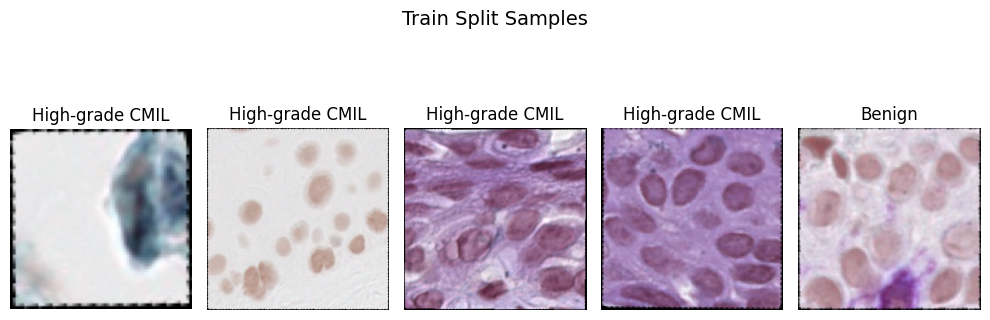


Train Set: Total Patches = 32875
  Benign (0):      16184
  High-grade (1):  16691

Validation Set: Total Patches = 12547
  Benign (0):      3849
  High-grade (1):  8698

Test Set: Total Patches = 14655
  Benign (0):      2791
  High-grade (1):  11864


In [ ]:
def visualize_random_samples(meta_df, title="Samples", n_samples=5, max_candidates=20, n_threads=5):
    """
    Efficiently sample & plot `n_samples` images by:
      - Sampling up to `max_candidates` rows
      - Loading in parallel (ThreadPoolExecutor of size `n_threads`)
      - Skipping unreadable files
    """
    # 1) pick up to max_candidates random rows
    sample_paths = meta_df.sample(
        n=min(max_candidates, len(meta_df)),
        random_state=42
    ).path.tolist()

    # 2) helper to try to open one image
    def try_load(path):
        try:
            img = Image.open(path).convert('RGB')
            arr = np.array(img) / 255.0
            return path, arr
        except Exception:
            return None

    # 3) load in parallel, stop once we have n_samples
    loaded = []
    with ThreadPoolExecutor(max_workers=n_threads) as exe:
        futures = { exe.submit(try_load, p): p for p in sample_paths }
        for fut in as_completed(futures):
            res = fut.result()
            if res:
                loaded.append(res)
            if len(loaded) >= n_samples:
                break

    if not loaded:
        print("⚠️  Could not load any sample images.")
        return

    # 4) plot however many we got (up to n_samples)
    n = len(loaded)
    fig, axes = plt.subplots(figsize=(10, 4), ncols=n)
    fig.suptitle(title, fontsize=14)
    for ax, (path, arr) in zip(axes, loaded):
        ax.imshow(arr)
        cid = int(case_pat.search(os.path.basename(path)).group(1))
        cls = "Benign" if labels_map[cid] == 0 else "High-grade CMIL"
        ax.set_title(cls)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


# Usage – should now be under 15 seconds:
visualize_random_samples(train_meta, title="Train Split Samples")

# ─── Step 10: Fast class-distribution counts ──────────────────────────────────
def print_meta_stats(name, meta_df):
    # count using metadata case_number → labels_map
    lbls = [ labels_map[cid] for cid in meta_df.case_number if cid in labels_map ]
    cnt = Counter(lbls)
    total = len(lbls)
    print(f"\n{name} Set: Total Patches = {total}")
    print(f"  Benign (0):      {cnt.get(0,0)}")
    print(f"  High-grade (1):  {cnt.get(1,0)}")

print_meta_stats("Train",      train_meta)
print_meta_stats("Validation", val_meta)
print_meta_stats("Test",       test_meta)


**8) Model Definition and Training**

**Define Generalized Model Traininng Function**

In [ ]:
# NEW TRAINING FUNCTION

# Helper: move tensors or lists of tensors to device
def move_batch_to_device(images, labels, device):
    if isinstance(images, (list, tuple)):
        images = torch.stack([img.to(device) for img in images])
    else:
        images = images.to(device)
    labels = labels.to(device)
    return images, labels

# Core training function
def train_model(model, optimizer, criterion, train_loader, val_loader, epochs=3,
                scheduler=None, resume_from=None, device='cuda' if torch.cuda.is_available() else 'cpu'):

    train_losses = []
    val_losses = []
    val_accuracies = []

    model_dir = "./models_5_13_k"
    os.makedirs(model_dir, exist_ok=True)

    model.to(device)
    best_acc = 0
    start_epoch = 0

    # Resume training if checkpoint exists
    if resume_from is not None and os.path.exists(resume_from):
        checkpoint = torch.load(resume_from, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_acc = checkpoint.get('val_accuracy', 0)
        print(f"🔁 Resumed from checkpoint at epoch {start_epoch} with accuracy {best_acc:.4f}")

    for e in range(start_epoch, epochs):
        model.train()
        running_loss = 0

        # Training phase
        train_bar = tqdm(train_loader, desc=f"Epoch {e+1}/{epochs}", leave=True)
        for images, labels, _ in train_bar:  # `_` = case_ids, ignored here
            images, labels = move_batch_to_device(images, labels, device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=running_loss / (train_bar.n + 1))

        epoch_train_loss = running_loss / len(train_loader)

        if scheduler:
            scheduler.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            validation_loss = 0
            correct = 0
            total = 0

            for images, labels, _ in val_loader:  # `_` = case_ids, ignored here
                images, labels = move_batch_to_device(images, labels, device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()

                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

            avg_val_loss = validation_loss / len(val_loader)
            val_accuracy = correct / total

        print(
            f"Epoch: {e+1}/{epochs}.. "
            f"Train Loss: {epoch_train_loss:.3f}.. "
            f"Val Loss: {avg_val_loss:.3f}.. "
            f"Val Accuracy: {val_accuracy:.3f}"
        )

        # Save checkpoint for every epoch
        torch.save({
            'epoch': e + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': avg_val_loss,
            'val_accuracy': val_accuracy
        }, os.path.join(model_dir, f"model_epoch_{e+1}.pth"))

        # Save best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), os.path.join(model_dir, "best_model.pth"))
            print(f"✅ New best model saved at epoch {e+1} with accuracy {val_accuracy:.4f}")

        train_losses.append(epoch_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    # Plot training metrics
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label='Training Loss')
    plt.plot(epochs_range, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss During Training')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy During Training')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

**Define Your Model and Train**

You need to specify 5 things (Do not specify anything else - they are already specified in the config)

1) Define your model object
```
model = models.alexnet(weights=models.AlexNet_Weights.DEFAULT) # Use updated weights API
```
2) Unfreeze any layers that you want
```
for p in model.parameters(): p.requires_grad=False
```

3) Replace the classifier head if you want



```
in_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_ftrs, 2)
```



4) Define the optimizer and pass your trainable parameters

```
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = CONFIG["lr"])
```

5) Optional: Define your class weighting (for class imbalance) and update the criterion

```
from collections import Counter

def compute_class_weights(meta_df, labels_map):
    # Extract per‐patch labels
    lbls = [
        labels_map[int(cid)]
        for cid in meta_df.case_number
        if int(cid) in labels_map
    ]
    cnt = Counter(lbls)
    total = sum(cnt.values())
    # Inverse frequency: heavier weight for under-represented class
    w0 = total / cnt.get(0, 1)
    w1 = total / cnt.get(1, 1)
    return [w0, w1]

class_weights = compute_class_weights(train_meta, labels_map)

# Then your weighted‐loss setup becomes:
cw_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=cw_tensor)

```

If you are having trouble implementing this, plug-in these instructions and your model into ChatGPT.

In [ ]:
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader
import gc  # For garbage collection
# === Helper: Replace BatchNorm2d with GroupNorm ===
def replace_bn_with_gn(module, num_groups=32):
    for name, child in module.named_children():
        if isinstance(child, nn.BatchNorm2d):
            num_channels = child.num_features
            setattr(module, name, nn.GroupNorm(num_groups=min(num_groups, num_channels), num_channels=num_channels))
        else:
            replace_bn_with_gn(child, num_groups=num_groups)

# === KimiaNet with GroupNorm ===
class KimiaNetClassifier(nn.Module):
    def __init__(self, num_classes=2, use_groupnorm=True):
        super(KimiaNetClassifier, self).__init__()
        base = models.densenet121(pretrained=False)

        if use_groupnorm:
            replace_bn_with_gn(base)

        self.features = base.features
        self.classifier = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.relu(x, inplace=True)
        x = F.adaptive_avg_pool2d(x, (1, 1)).view(x.size(0), -1)
        return self.classifier(x)

# === Setup ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = KimiaNetClassifier(num_classes=2).to(device)

# Load weights (skip classifier mismatch)
state_dict = torch.load('/content/drive/MyDrive/KimiaNetPyTorchWeights.pth', map_location=device)
filtered_state_dict = {k: v for k, v in state_dict.items() if not k.startswith('classifier')}
model.load_state_dict(filtered_state_dict, strict=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1/3:   0%|          | 0/16438 [00:00<?, ?it/s]

Epoch: 1/3.. Train Loss: 0.461.. Val Loss: 0.818.. Val Accuracy: 0.615
✅ New best model saved at epoch 1 with accuracy 0.6149


Epoch 2/3:   0%|          | 0/16438 [00:00<?, ?it/s]

Epoch: 2/3.. Train Loss: 0.333.. Val Loss: 0.744.. Val Accuracy: 0.698
✅ New best model saved at epoch 2 with accuracy 0.6975


Epoch 3/3:   0%|          | 0/16438 [00:00<?, ?it/s]

Epoch: 3/3.. Train Loss: 0.277.. Val Loss: 0.618.. Val Accuracy: 0.721
✅ New best model saved at epoch 3 with accuracy 0.7214


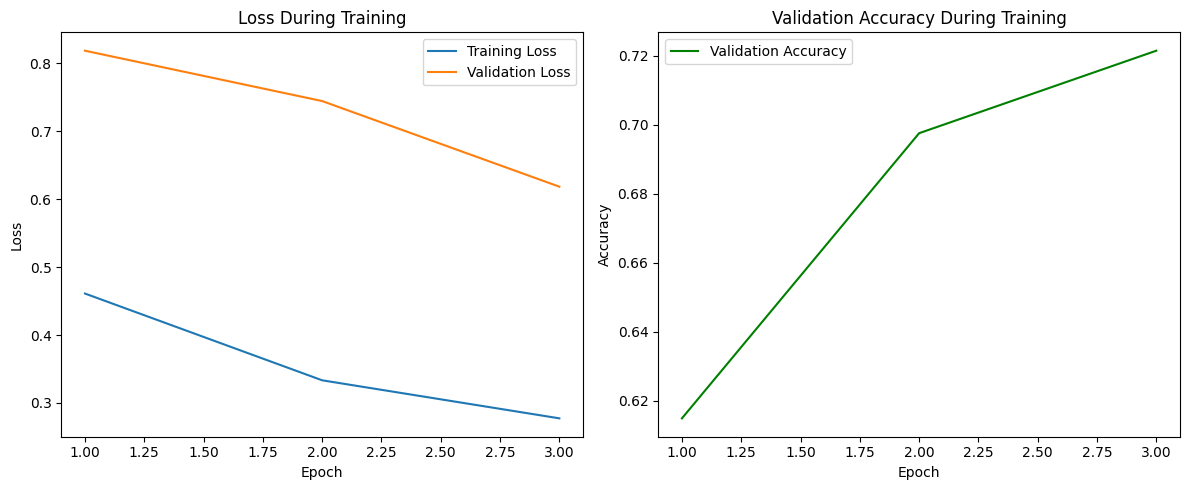

In [ ]:
# train model
trained_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=CONFIG['num_epochs'],
    scheduler=None,         # Optional: Replace with lr_scheduler if used
    resume_from=None,       # Optional: Replace with path to checkpoint if resuming
    device=CONFIG['device'] # Automatically uses 'cuda' or 'cpu'
)

**9. Model Evaluation**


=== Test Set Performance ===
Accuracy      : 0.7275
Precision     : 0.9000
Recall        : 0.7463
F1 Score      : 0.8160

Classification Report:
                 precision    recall  f1-score   support

         Benign       0.38      0.65      0.48      2791
High-grade CMIL       0.90      0.75      0.82     11864

       accuracy                           0.73     14655
      macro avg       0.64      0.70      0.65     14655
   weighted avg       0.80      0.73      0.75     14655



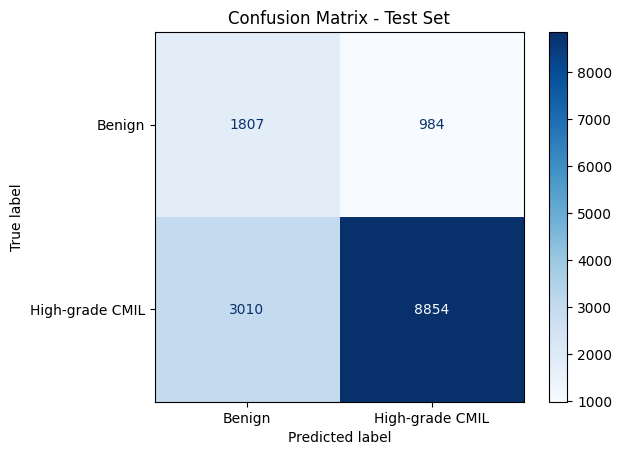

In [ ]:
def evaluate_model_on_test(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels, _ in test_loader:  # `_` = case IDs (optional)
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # === Compute Metrics ===
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print("\n=== Test Set Performance ===")
    print(f"Accuracy      : {acc:.4f}")
    print(f"Precision     : {prec:.4f}")
    print(f"Recall        : {rec:.4f}")
    print(f"F1 Score      : {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=["Benign", "High-grade CMIL"]))

    # === Plot Confusion Matrix ===
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "High-grade CMIL"])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix - Test Set")
    plt.show()

# === Run Evaluation ===
evaluate_model_on_test(trained_model, test_loader, CONFIG['device'])


**10. Patch Level to Case Level Prediction**

In [ ]:
# === STEP 1: Create labels_map from CSV with string labels ===
import pandas as pd

label_df = pd.read_csv("/content/drive/MyDrive/ML model comparison - Train-test split.csv")
class_map = {"Benign": 0, "High-grade": 1}
labels_map = {
    int(row.Case): class_map.get(row["class"], -1)
    for _, row in label_df.iterrows()
}

# === STEP 2: Full case-level evaluation function ===
def evaluate_model_case_level_svc(
    model, df_train, df_test, train_loader, test_loader,
    labels_map, k=25, tune_svc=False, return_pred=False, device='cuda'
):
    from sklearn.svm import SVC, LinearSVC
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score,
        f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
    )
    import matplotlib.pyplot as plt

    model.eval()
    all_probs_tr, all_probs_tst = [], []

    with torch.no_grad():
        for images, _, _ in train_loader:
            images = images.to(device)
            probs = torch.nn.functional.softmax(model(images), dim=1)
            all_probs_tr.extend(probs.cpu().numpy())

        for images, _, _ in test_loader:
            images = images.to(device)
            probs = torch.nn.functional.softmax(model(images), dim=1)
            all_probs_tst.extend(probs.cpu().numpy())

    train_prob = [arr[0] for arr in all_probs_tr]
    test_prob = [arr[0] for arr in all_probs_tst]

    # === TRAIN SET ===
    df_train = df_train.copy()
    df_train['label'] = df_train['case_number'].map(labels_map)

    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_stain = df_train[df_train['stain'] == stain].reset_index(drop=True)
            stain_probs = [train_prob[i] for i in df_stain.index]
            stain_top_k = pd.DataFrame({
                'case_number': df_stain.case_number.values,
                'prob': stain_probs
            }).groupby('case_number', group_keys=False).apply(
                lambda x: x.nlargest(k, columns='prob')
            ).reset_index(drop=True)
            stain_top_k['rank'] = stain_top_k.groupby('case_number').cumcount()
            stain_top_k = stain_top_k.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k.columns = [f'{stain}_prob_{i}' for i in stain_top_k.columns]
            all_top_k.append(stain_top_k)
        top_k_prob = pd.concat(all_top_k, axis=1).dropna()
    else:
        top_k_prob = pd.DataFrame({
            'case_number': df_train.case_number.values,
            'prob': train_prob
        }).groupby('case_number', group_keys=False).apply(
            lambda x: x.nlargest(k, columns='prob')
        ).reset_index(drop=True)
        top_k_prob['rank'] = top_k_prob.groupby('case_number').cumcount()
        top_k_prob = top_k_prob.pivot(index='case_number', columns='rank', values='prob').dropna()

    case_label = df_train[df_train.case_number.isin(top_k_prob.index)] \
                    .groupby('case_number')['label'].mean()

    # === Train SVC ===
    if tune_svc:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC())
        ])
        param_grid = [
            {'svc__kernel': ['linear'], 'svc__C': [0.01, 0.1, 1, 10, 100]},
            {'svc__kernel': ['rbf'], 'svc__C': [0.1, 1, 10], 'svc__gamma': ['scale', 0.01, 0.001, 0.0001]}
        ]
        svc = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
        svc.fit(top_k_prob, case_label)
        print("Selected parameters:", svc.best_params_)
    else:
        svc = make_pipeline(StandardScaler(), LinearSVC())
        svc.fit(top_k_prob, case_label)

    # === TEST SET ===
    df_test = df_test.copy()
    df_test['label'] = df_test['case_number'].map(labels_map)

    if df_train['stain'].nunique() > 1:
        all_top_k = []
        for stain in df_train['stain'].unique():
            df_stain = df_test[df_test['stain'] == stain].reset_index(drop=True)
            stain_probs = [test_prob[i] for i in df_stain.index]
            stain_top_k = pd.DataFrame({
                'case_number': df_stain.case_number.values,
                'prob': stain_probs
            }).groupby('case_number', group_keys=False).apply(
                lambda x: x.nlargest(k, columns='prob')
            ).reset_index(drop=True)
            stain_top_k['rank'] = stain_top_k.groupby('case_number').cumcount()
            stain_top_k = stain_top_k.pivot(index='case_number', columns='rank', values='prob').dropna()
            stain_top_k.columns = [f'{stain}_prob_{i}' for i in stain_top_k.columns]
            all_top_k.append(stain_top_k)
        top_k_prob_tst = pd.concat(all_top_k, axis=1).dropna()
    else:
        top_k_prob_tst = pd.DataFrame({
            'case_number': df_test.case_number.values,
            'prob': test_prob
        }).groupby('case_number', group_keys=False).apply(
            lambda x: x.nlargest(k, columns='prob')
        ).reset_index(drop=True)
        top_k_prob_tst['rank'] = top_k_prob_tst.groupby('case_number').cumcount()
        top_k_prob_tst = top_k_prob_tst.pivot(index='case_number', columns='rank', values='prob').dropna()

    case_label_tst = df_test[df_test.case_number.isin(top_k_prob_tst.index)] \
                        .groupby('case_number')['label'].mean()

    # === Handle missing labels ===
    case_label_tst = case_label_tst.fillna(-1)
    missing = case_label_tst[case_label_tst == -1].index.tolist()
    if missing:
        print(f"⚠️ {len(missing)} test cases have missing labels and will be excluded from evaluation metrics.")
        print("Missing-label case numbers:", missing)

    # Predict on all test cases
    test_pred = svc.predict(top_k_prob_tst)

    # Filter for valid test cases for evaluation
    valid_mask = case_label_tst != -1
    case_label_eval = case_label_tst[valid_mask]
    test_pred_eval = test_pred[valid_mask]

    # === Metrics ===
    print("\\n=== Train Set Performance ===")
    train_pred = svc.predict(top_k_prob)
    print(f"Accuracy:  {accuracy_score(case_label, train_pred):.4f}")
    print(f"Precision: {precision_score(case_label, train_pred):.4f}")
    print(f"Recall:    {recall_score(case_label, train_pred):.4f}")
    print(f"F1 Score:  {f1_score(case_label, train_pred):.4f}")

    print("\\n=== Test Set Performance ===")
    print(f"Accuracy:  {accuracy_score(case_label_eval, test_pred_eval):.4f}")
    print(f"Precision: {precision_score(case_label_eval, test_pred_eval):.4f}")
    print(f"Recall:    {recall_score(case_label_eval, test_pred_eval):.4f}")
    print(f"F1 Score:  {f1_score(case_label_eval, test_pred_eval):.4f}")
    print("\\nClassification Report:")
    print(classification_report(case_label_eval, test_pred_eval, target_names=["Benign", "High-grade CMIL"]))

    cm = confusion_matrix(case_label_eval, test_pred_eval)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.xticks([0, 1], ['Benign', 'High-grade CMIL'])
    plt.yticks([0, 1], ['Benign', 'High-grade CMIL'])
    plt.xlabel('Predicted Case Grade')
    plt.ylabel('Actual Case Grade')
    plt.title("Confusion Matrix - Test Set Case Level")
    plt.show()

    # === Predictions for missing-label cases ===
    if missing:
        print("\\n🔍 Predictions for test cases with missing labels:")
        for cid, pred in zip(case_label_tst.index[~valid_mask], test_pred[~valid_mask]):
            label_str = "Benign" if pred == 0 else "High-grade CMIL"
            print(f"Case {cid}: predicted → {label_str}")

    if return_pred:
        return test_pred
    return None


<ipython-input-44-c686a0b3a541>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  }).groupby('case_number', group_keys=False).apply(
<ipython-input-44-c686a0b3a541>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  }).groupby('case_number', group_keys=False).apply(
<ipython-input-44-c686a0b3a541>:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, an

Selected parameters: {'svc__C': 0.01, 'svc__kernel': 'linear'}
\n=== Train Set Performance ===
Accuracy:  0.6818
Precision: 0.6818
Recall:    1.0000
F1 Score:  0.8108
\n=== Test Set Performance ===
Accuracy:  0.6923
Precision: 0.6923
Recall:    1.0000
F1 Score:  0.8182
\nClassification Report:
                 precision    recall  f1-score   support

         Benign       0.00      0.00      0.00         4
High-grade CMIL       0.69      1.00      0.82         9

       accuracy                           0.69        13
      macro avg       0.35      0.50      0.41        13
   weighted avg       0.48      0.69      0.57        13



<ipython-input-44-c686a0b3a541>:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  }).groupby('case_number', group_keys=False).apply(
<ipython-input-44-c686a0b3a541>:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  }).groupby('case_number', group_keys=False).apply(
<ipython-input-44-c686a0b3a541>:105: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated,

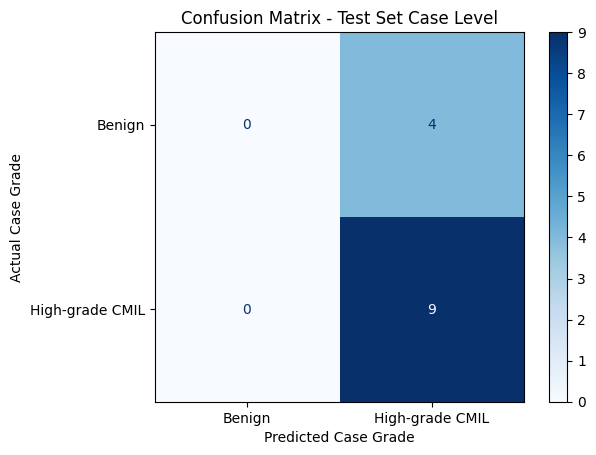

In [ ]:
# === Run Case-Level Model Evaluation ===
evaluate_model_case_level_svc(model, train_meta, test_meta, train_loader, test_loader, labels_map = labels_map, k = 25, tune_svc=True)

**End of script – see below for other examples of correct model setups**